✞ *For the protection of wisdom is like the protection of money, and the advantage of knowledge is that wisdom preserves the life of him who has it.* ✞

#### Imports

In [1]:
import timeit
start_time = timeit.default_timer()

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from cairosvg import svg2png
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage.interpolation import shift
# from sklearn.metrics import roc_auc_score

pd.set_option('display.max_rows', 100)
# pd.set_option('display.float_format', lambda x: '%.5f' % x)

KAGGLE = 0
print('Import packages')

Import packages


In [3]:
# RIIID env init
if KAGGLE:
    import riiideducation

    env = riiideducation.make_env()

#### Global Variables

In [4]:
print('global variables')
TRAIN_CSV_PATH = 'train.feather'
QUESTIONS_CSV_PATH = 'questions.csv'
LECTURES_CSV_PATH = 'lectures.csv'
SAMPLE_CSV_PATH = 'example_sample_submission.csv'
SAMPLE_TEST_CSV_PATH = 'example_test.csv'

if KAGGLE:
    TRAIN_CSV_PATH = '../input/myriiddataset/train.feather'
    QUESTIONS_CSV_PATH = '../input/myriiddataset/questions.featherr'
    LECTURES_CSV_PATH = '../input/myriiddataset/lectures.feather'
    SAMPLE_TEST_CSV_PATH = '../input/riiid-test-answer-prediction/example_test.csv'

COLUMN_TYPES = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

global variables


In [5]:
# train_df = pd.read_csv(TRAIN_CSV_PATH, nrows=10**5, dtype=COLUMN_TYPES)
train_df = pd.read_feather(TRAIN_CSV_PATH)
target_df = train_df[50000000:52500000]
train_df = train_df.iloc[:1 * (10 ** 3)]
if KAGGLE:
    questions_df = pd.read_feather(QUESTIONS_CSV_PATH)
    lectures_df = pd.read_feather(LECTURES_CSV_PATH)
else:
    questions_df = pd.read_csv(QUESTIONS_CSV_PATH)
    lectures_df = pd.read_csv(LECTURES_CSV_PATH)
    sample_test_df = pd.read_csv(SAMPLE_TEST_CSV_PATH)

### Common Variables

In [6]:
# The question based information dict
# NOTE: generated only after we move to the training data
individual_question_min_time_dict = {}
individual_question_mean_time_dict = {}
average_question_timestamp_difference_dict = {}
bundle_time_relation_dict = {}

# check average user answering time
user_average_time_to_elapsed_dict = train_df[['user_id', 'prior_question_elapsed_time']].groupby("user_id").prior_question_elapsed_time.mean().to_dict()
# check average question answering time
average_question_prior_question_elapsed_time_dict = train_df[['content_id', 'prior_question_elapsed_time']].groupby(["content_id"]).prior_question_elapsed_time.mean().to_dict()
# The correct answered questions
check_answered_correctly = (train_df.answered_correctly == 1)
question_rows = (train_df.content_type_id == 0)

print('common variables')

common variables


### Check for question specific features

In [7]:
questions_df[questions_df.tags.isna()] = questions_df[questions_df.tags.isna()].fillna("")
questions_df[questions_df.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags


In [8]:
tag_counts = questions_df[['tags', 'question_id']].groupby('tags')['tags'].count()
tag_counts_list = list(tag_counts.sort_values().index.values)
questions_df['tag_count_wise_id'] = questions_df.apply(lambda row: tag_counts_list.index(row.tags), axis=1)

In [9]:
# Find the wrong and right question tags based on correctly answered
tags_list = [value.split() for value in questions_df.tags.values]

questions_df['tags_list'] = tags_list
questions_df['number_of_tags'] = questions_df.apply(lambda row: len(row.tags), axis=1)
questions_df['tags'] = questions_df['tags'].astype(str)

questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12


In [10]:
# The part content type of the question wheather if it is a listening section or a reading secition
questions_df['part_test_listening'] = True
reading_sections_parts = [5, 6, 7]
questions_df.loc[questions_df.part.isin(reading_sections_parts), 'part_test_listening'] = False
questions_df.part_test_listening.unique()

array([ True, False])

In [11]:
# get all the complete tags of the question
tags = [value.split() for value in questions_df[questions_df.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)

In [12]:
# Question dict
question_dict = questions_df[['question_id', 'tags', 'part', 'bundle_id', 'tags_list']].set_index('question_id').to_dict(orient='index')

In [13]:
questions_df[questions_df['question_id'] == 5692]

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening
5692,5692,5692,3,5,151,1364,[151],3,False


In [14]:
# Find the wrong and right question based on correctly answered
correct = train_df.loc[question_rows, ['content_id', 'answered_correctly']].groupby(['content_id', 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= 'content_id', columns='answered_correctly', values='size')
correct.columns = ['wrong', 'right']
correct = correct.fillna(0)
correct[['wrong', 'right']] = correct[['wrong', 'right']].astype(int)
questions_df = questions_df.merge(correct, left_on = 'question_id', right_on = 'content_id', how = 'left')
questions_df['percentage_correct'] = questions_df.right / (questions_df.right + questions_df.wrong)
questions_df.head()

# questions_df.drop(['wrong_x', 'right_x', 'wrong_y', 'right_y'], axis=1, inplace=True)

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening,wrong,right,percentage_correct
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13,True,NaN,NaN,NaN
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9,True,NaN,NaN,NaN
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14,True,1.0,0.0,0.0
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14,True,NaN,NaN,NaN
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12,True,1.0,0.0,0.0


In [15]:
# TODO: This seems to be wrong please check again
train_df.loc[question_rows, ['question_bundle_id']] = train_df.loc[question_rows, ['content_id']].apply(lambda row: question_dict[row.content_id].get('bundle_id'), axis=1)
correct = train_df.loc[question_rows, ['question_bundle_id', 'answered_correctly']].groupby(["question_bundle_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "question_bundle_id", columns='answered_correctly', values='size')
correct.columns = ['bundle_wrong', 'bundle_right']
correct = correct.fillna(0)
correct[['bundle_wrong', 'bundle_right']] = correct[['bundle_wrong', 'bundle_right']].astype(int)

questions_df = questions_df.merge(correct, left_on = "bundle_id", right_on = "question_bundle_id", how = "left")
questions_df['task_percentage_correct'] = questions_df.bundle_right / (questions_df.bundle_right + questions_df.bundle_wrong)
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening,wrong,right,percentage_correct,bundle_wrong,bundle_right,task_percentage_correct
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13,True,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9,True,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14,True,1.0,0.0,0.0,1.0,0.0,0.0
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14,True,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12,True,1.0,0.0,0.0,1.0,0.0,0.0


In [16]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions_df[questions_df.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'wrong': ['sum'], 'right': ['sum']})
    df1['total_questions'] = df1.wrong + df1.right
    df1['question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['wrong', 'right', 'total_questions']] = tags_df[['wrong', 'right', 'total_questions']].astype(int)
tags_df['percent_correct'] = tags_df.right / tags_df.total_questions
tags_df = tags_df.sort_values(by = "percent_correct")

tags_df.head()

,wrong,right,total_questions,question_ids_with_tag,percent_correct
tag,,,,,
50,4,0,4,73,0.0
124,4,0,4,12,0.0
170,3,0,3,25,0.0
123,1,0,1,29,0.0
134,2,0,2,65,0.0


In [17]:
question_dict = questions_df[['question_id', 'percentage_correct', 'tags', 'part', 'bundle_id', 'tags_list']].set_index('question_id').to_dict(orient='index')

print('question specific functions')


question specific functions


### The lecture specific data creation

In [18]:
# The lecture based dict for type of and part
lecture_dict = lectures_df.set_index("lecture_id").to_dict(orient="index")
lecture_comprehensive_type_of_dict = lectures_df.set_index('type_of').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()
lecture_comprehensive_part_dict = lectures_df.set_index('part').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()

In [19]:
for key in lecture_comprehensive_part_dict:
    lecture_comprehensive_part_dict[key]['tag'] = list(set(lecture_comprehensive_part_dict[key]['tag']))
    lecture_comprehensive_part_dict[key]['type_of'] = list(set(lecture_comprehensive_part_dict[key]['type_of']))

for key in lecture_comprehensive_type_of_dict:
    lecture_comprehensive_type_of_dict[key]['tag'] = list(set(lecture_comprehensive_type_of_dict[key]['tag']))
    lecture_comprehensive_type_of_dict[key]['part'] = list(set(lecture_comprehensive_type_of_dict[key]['part']))

print('lecture specific')

lecture specific


### Common function

In [20]:
def convert_timestamp_in_parts(millis):
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours, minutes, seconds

def get_timestamp_in_parts(row):
    millis = row.timestamp
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours

def get_prior_elasped_time_in_parts(row):
    prior_millis = row.prior_question_elapsed_time
    prior_seconds = (prior_millis / 1000)
    prior_minutes = (prior_seconds / 60)
    return prior_minutes

In [35]:
# Retention
# https://en.wikipedia.org/wiki/Forgetting_curve
# https://psychology.stackexchange.com/questions/5199/which-equation-is-ebbinghauss-forgetting-curve-and-what-do-the-constants-repres
def apply_filter_based_on_previous_row(func):
    prev_row = {
        "has_seen_lecture": False,
        "previous_lecture_hours": 0,
        "previous_lecture": {},
        "user_id": ""
    }
    def wrapper(curr_row, **kwargs):
        content_id = curr_row.content_id
        tag_of_prev_lecture = 0
        part_of_prev_lecture = 0
        has_seen_same_tag_as_lecture = False
        has_seen_same_part_as_lecture = False
        has_part_common_with_type_of = False
        has_tag_common_with_type_of = False
        has_tag_common_with_part_dict = False
        has_type_of_common_with_part_dict = False
        event_in_hours = get_timestamp_in_parts(curr_row)[1]
        if prev_row['user_id'] == curr_row.user_id:
            if curr_row.content_type_id != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = event_in_hours
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                has_seen_same_tag_as_lecture = (str(prev_row['previous_lecture'].get("tag", "")) in str(question_dict[content_id]['tags']).split())
                has_seen_same_part_as_lecture = (prev_row['previous_lecture'].get("part") == question_dict[content_id]['part'])
                prev_type_of = prev_row['previous_lecture'].get("type_of")
                prev_part = prev_row['previous_lecture'].get("part")
                has_part_common_with_type_of = question_dict[content_id]['part'] in  lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('part', [])
                has_tag_common_with_type_of = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('tag', [])))
                has_tag_common_with_part_dict = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_part_dict.get(prev_part, {}).get('tag', [])))
                has_type_of_common_with_part_dict = prev_type_of in lecture_comprehensive_part_dict[question_dict[content_id]['part']]['type_of']
                tag_of_prev_lecture = prev_row['previous_lecture'].get('tag', 0)
                part_of_prev_lecture = prev_row['previous_lecture'].get('part', 0)
        else:
            prev_row['user_id'] = curr_row.user_id
            if curr_row.content_type_id != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = event_in_hours
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                prev_row['has_seen_lecture'] = False
                prev_row['previous_lecture_hours'] = 0
                prev_row['previous_lecture'] = {}

        timestamp_difference = event_in_hours - prev_row['previous_lecture_hours']
        retention = func(timestamp_difference)
        return retention, tag_of_prev_lecture, part_of_prev_lecture, prev_row['has_seen_lecture'], has_seen_same_tag_as_lecture, has_seen_same_part_as_lecture, has_part_common_with_type_of, has_tag_common_with_type_of, has_tag_common_with_part_dict, has_type_of_common_with_part_dict

    return wrapper

@apply_filter_based_on_previous_row
def running_retention(timestamp_difference):
    retention = 1.48 / ((1.25 * timestamp_difference) + 1.48)
    return retention

In [40]:
def get_shift_values(df, groupby=True):
    if groupby:
        user_group_by = df[['user_id', 'timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation']].groupby('user_id')
    else:
        user_group_by = df
    event_time = user_group_by['timestamp'].diff()
    shift_event_time = shift(event_time, -1, cval=np.NaN)
    shift_elapsed_time = user_group_by.prior_question_elapsed_time.shift(-1)
    shift_prior_question_had_explanation = user_group_by.prior_question_had_explanation.shift(-1)

    event_lag_time = shift_event_time - shift_elapsed_time
    return event_time.values, shift_event_time, shift_elapsed_time.values, shift_prior_question_had_explanation.values, event_lag_time.values

def get_prior_elapsed_time_difference(content_id, shift_elapsed_time):
    question_min_time = individual_question_min_time_dict.get(content_id, shift_elapsed_time)
    return shift_elapsed_time - question_min_time

In [23]:
# function to check based on the average time taken for question
def has_elapsed_time_greater_than_average_time(content_id, shift_elapsed_time):
    question_min_time = individual_question_mean_time_dict.get(content_id, shift_elapsed_time)
    return shift_elapsed_time > question_min_time

def has_event_time_greater_than_average(content_id, event_time):
    average_question_time = average_question_timestamp_difference_dict.get(content_id, event_time)
    return event_time > average_question_time

In [32]:
# TODO: Too heavy function
# Question time list
bundle_time_relation_dict = {}
prev_row = {
    "user_id": "",
    "bundle_id": "",
    "previous_bundle_elapsed_time": ""
}


def get_question_time_taken(curr_row):
    current_bundle_id = question_dict[curr_row.content_id]['bundle_id']
    if prev_row['user_id'] == curr_row.user_id:
        if prev_row['bundle_id'] == current_bundle_id:
            time_taken_for_question = prev_row['previous_bundle_elapsed_time']
        else:
            time_taken_for_question = curr_row.prior_question_elapsed_time
            prev_row['previous_bundle_elapsed_time'] = curr_row.prior_question_elapsed_time
            prev_row['bundle_id'] = current_bundle_id
    else:
        prev_row['bundle_id'] = current_bundle_id
        prev_row['previous_bundle_elapsed_time'] = curr_row.prior_question_elapsed_time
        time_taken_for_question = 0
    prev_row['user_id'] = curr_row.user_id
    return time_taken_for_question


for index, row in train_df.loc[question_rows, ['timestamp', 'content_id', 'user_id', 'prior_question_elapsed_time']].iloc[::-1].iterrows():
    if row.content_id in bundle_time_relation_dict and bundle_time_relation_dict:
        bundle_time_relation_dict[row.content_id]['question_time_list'].append(get_question_time_taken(row))
    else:
        bundle_time_relation_dict[row.content_id] = {
            "question_time_list": [get_question_time_taken(row)]
        }

for content_id in bundle_time_relation_dict.keys():
    bundle_time_relation_dict[content_id]['minimum_time'] = min(bundle_time_relation_dict[content_id]['question_time_list'])
    bundle_time_relation_dict[content_id]['average_time'] = np.mean(bundle_time_relation_dict[content_id]['question_time_list'])

In [33]:
def get_bundle_lag_time(row):
    minmum_time = bundle_time_relation_dict.get(row.content_id, {'minimum_time': 0})['minimum_time']
    if row.shift_elapsed_time > minmum_time:
        return row.shift_elapsed_time - minmum_time
    return 0

In [34]:
# TODO: please check the values that is used in each question they might be wrong
def is_question_above_average_answering(row):
    percentage_correct = question_dict[row.content_id].get('percentage_correct')
    if percentage_correct:
        return percentage_correct > 50
    return False

def is_all_tags_above_average_answering(row):
    tags_answer_percentages = []
    tags = question_dict[row.content_id].get('tags_list')
    if not tags:
        return False
    tags = tags
    for tag in tags:
        tags_answer_percentages.append(tags_df.loc[tag].percent_correct)
    overall_tag_percentage = sum(tags_answer_percentages) / len(tags)
    return overall_tag_percentage > 0.5

In [27]:
def get_sum_std_correctness(df, group_by_feature, target):
    feature_agg = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['sum', 'count','var'])
    feature_agg = feature_agg.astype('float32')

    df = df.replace([np.inf, -np.inf], np.nan)
    feature_sum = df[group_by_feature].map(feature_agg['sum']).fillna(0).astype('int32')
    feature_std = df[group_by_feature].map(feature_agg['var']).fillna(0).astype('float16')
    feature_correctness = df[group_by_feature].map(feature_agg['sum'] / feature_agg['count'])

    feature_correctness = feature_correctness.astype('float16')
    return feature_sum.values, feature_std.values, feature_correctness.values

def get_sum_std_correctness_agg_dict(df, group_by_feature, target):
    feature_agg = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['sum', 'count','var'])
    feature_agg = feature_agg.astype('float32')

    feature_sum_dict = (feature_agg['sum']).fillna(0).astype('int32').to_dict()
    feature_var_dict = (feature_agg['var']).fillna(0).astype('float16').to_dict()
    feature_count_dict = (feature_agg['count']).fillna(0).astype('float16').to_dict()
    feature_correctness = (feature_agg['sum'] / feature_agg['count'])
    feature_correctness = feature_correctness.astype('float16')
    feature_correctness_dict = feature_correctness.to_dict()

    return feature_sum_dict, feature_var_dict, feature_count_dict, feature_correctness_dict

def get_cum_sum_std_correctness(df, group_by_feature, target):
    cum = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['cumsum', 'cumcount'])
    feature_cum_correctness = cum['cumsum'] / cum['cumcount']
    feature_correct_cumsum = cum['cumsum'].fillna(0)
    feature_correct_cumcount = cum['cumcount'].fillna(0)

    feature_cum_correctness = feature_cum_correctness.astype('float16')
    feature_correct_cumcount = feature_correct_cumcount.astype('int16')
    feature_correct_cumsum = feature_correct_cumsum.astype('int16')
    return feature_cum_correctness.values, feature_correct_cumcount.values, feature_correct_cumsum.values

def get_cum_sum_std_correctness_dict(df, group_by_feature, target):
    cum = df[[group_by_feature, target]].groupby(group_by_feature)[target].agg(['cumsum', 'cumcount'])
    feature_cum_correctness = cum['cumsum'] / cum['cumcount']
    feature_cum_correctness = feature_cum_correctness.astype('float16')
 
    feature_correct_cumsum = cum['cumsum'].fillna(0).astype('int16')
    feature_correct_cumcount = cum['cumcount'].fillna(0).astype('int16')

    feature_cum_correctness_dict = feature_cum_correctness.to_dict()
    feature_correct_cumsum_dict = feature_correct_cumsum.to_dict()
    feature_correct_cumcount_dict = feature_correct_cumcount.to_dict()

    return feature_cum_correctness_dict, feature_correct_cumsum_dict, feature_correct_cumcount_dict

print('common functions')

common functions


### Prepare first group test set with train_df

### Set User specific features

In [28]:
train_df.sort_values(['user_id', 'timestamp'], inplace=True)

##### 1. Get timestamp as hours and minutes

In [29]:
train_df[['event_in_days', 'event_in_hours']] = [*train_df[['timestamp']].apply(lambda row: get_timestamp_in_parts(row), axis=1)]
train_df['prior_minutes'] = train_df[['prior_question_elapsed_time']].apply(lambda row: get_prior_elasped_time_in_parts(row), axis=1)

##### 2. Find the intro rows.

In [30]:
# TODO: The intro section can also be calculated based on the bundle id
train_df['intro_section'] = False
train_df.loc[((train_df.timestamp == 0) | (train_df.task_container_id == 0)), 'intro_section'] = True
intro_section_values = train_df[train_df['intro_section'] == True].content_id.unique()
train_df.loc[train_df['content_id'].isin(intro_section_values), 'intro_section'] = True
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_bundle_id,event_in_days,event_in_hours,prior_minutes,intro_section
0,0,0,115,5692,0,1,3,1,NaN,<NA>,5692.0,0.000000,0.000000,NaN,True
1,1,56943,115,5716,0,2,2,1,37000.0,False,5716.0,0.000659,0.015817,0.616667,False
2,2,118363,115,128,0,0,0,1,55000.0,False,128.0,0.001370,0.032879,0.916667,True
3,3,131167,115,7860,0,3,0,1,19000.0,False,7860.0,0.001518,0.036435,0.316667,False
4,4,137965,115,7922,0,4,1,1,11000.0,False,7922.0,0.001597,0.038324,0.183333,False


##### 3. The actions after the lectures should be tagged with something.

In [37]:
train_df["retention"], train_df["previous_lecture_tag"], train_df["previous_lecture_part"], train_df["has_seen_lecture_before"], train_df["has_seen_same_tag_as_lecture"], train_df["has_seen_same_part_as_lecture"], train_df["has_part_common_with_type_of"], train_df["has_tag_common_with_type_of"], train_df["has_tag_common_with_part_dict"], train_df["has_type_of_common_with_part_dict"] = zip(*train_df[['user_id', 'content_id', 'content_type_id', 'event_in_hours','timestamp']].apply(running_retention, axis=1))

In [38]:
# Make train df only question and not lectures
train_df = train_df[train_df['content_type_id'] == 0]

##### 4. Now lets find out the lag time

In [41]:
train_df[['event_time', 'shift_event_time', 'shift_elapsed_time', 'has_seen_question_explanation', 'event_lag_time']] = list(zip(*get_shift_values(train_df[['user_id', 'timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation']])))

train_df_elapsed_time_groupby = train_df[['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time

individual_question_min_time_dict = train_df_elapsed_time_groupby.min().to_dict()
individual_question_mean_time_dict = train_df_elapsed_time_groupby.mean().to_dict()

average_question_timestamp_difference_dict = train_df.loc[(train_df['shift_event_time'] < 3600000), ['content_id', 'shift_event_time']][['content_id', 'shift_event_time']].groupby('content_id').shift_event_time.mean().to_dict()

del train_df_elapsed_time_groupby

In [42]:
train_df['lag_time'] = train_df[['content_id', 'shift_elapsed_time']].apply(lambda row: get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time), axis=1)

train_df['bundle_lag_time'] = train_df[['content_id', 'shift_elapsed_time']].apply(lambda row: get_bundle_lag_time(row), axis=1)

train_df['question_answered_late'] = train_df[['content_id', 'shift_elapsed_time']].apply(lambda row: has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time), axis=1)

train_df['event_time_greater_than_average'] = train_df[['content_id', 'shift_event_time']].apply(lambda row: has_event_time_greater_than_average(row.content_id, row.shift_event_time), axis=1)

##### 5. lets find the average time took for each question

In [43]:
# The average time per question can be considered based on the every candidate or based on the current candidate previous question answering time.

In [44]:
train_df['question_took_less_than_average_user_time'] = train_df[['prior_question_elapsed_time', 'user_id']].apply(lambda row: row.prior_question_elapsed_time < user_average_time_to_elapsed_dict.get(row.user_id, 0), axis=1)

train_df['question_took_less_than_average_content_time'] = train_df[['prior_question_elapsed_time', 'user_id']].apply(lambda row: row.prior_question_elapsed_time < average_question_prior_question_elapsed_time_dict.get(row.user_id, 0), axis=1)

train_df['has_less_than_average_bundle_time'] = train_df[['shift_elapsed_time', 'content_id']].apply(lambda row: row.shift_elapsed_time < bundle_time_relation_dict.get(row.content_id, {"average_time": 0})['average_time'], axis=1)

##### 6. Find the toughest questions

In [45]:
train_df['question_has_above_average_correctness'] = train_df[['content_id']].apply(lambda row: is_question_above_average_answering(row), axis=1)

train_df['tag_has_above_average_correctness'] = train_df[['content_id']].apply(lambda row: is_all_tags_above_average_answering(row), axis=1)

##### 6. toughtest questions relates to the lag time and the elapsed time

In [46]:
lag_time_answered_correctly_mean_dict = train_df[check_answered_correctly][['content_id', 'lag_time']].groupby(['content_id']).lag_time.mean().to_dict()

train_df['has_above_average_lag_time_for_the_question'] = train_df[['lag_time', 'content_id']].apply(lambda row: row.lag_time > lag_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

In [47]:
shift_elapsed_time_answered_correctly_mean_dict = train_df[check_answered_correctly][['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time.mean().to_dict()

train_df['has_above_average_shift_elpased_time_for_the_question'] = train_df[['shift_elapsed_time', 'content_id']].apply(lambda row: row.shift_elapsed_time > shift_elapsed_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

##### 7. The prior time mean for each user should be averaged to check if the user too more than usual

In [48]:
# TODO: Do the following by setting the time rather than setting the flag
# BUG: The comparison seems to be wrong 
elapsed_time_mean_dict = train_df[check_answered_correctly][['shift_elapsed_time', 'user_id']].groupby('user_id').shift_elapsed_time.mean().to_dict()

train_df['has_above_user_average_time_to_answer'] = train_df[['user_id', 'shift_elapsed_time']].apply(lambda row: elapsed_time_mean_dict.get(row.user_id, 0) <= row.shift_elapsed_time, axis=1)

In [49]:
event_time_mean_dict = train_df[check_answered_correctly][['event_time', 'user_id']].groupby('user_id').event_time.mean().to_dict()

train_df['has_above_user_average_time_for_event'] = train_df[['user_id', 'event_time']].apply(lambda row: event_time_mean_dict.get(row.user_id, 0) <= row.event_time, axis=1)

In [50]:
shift_event_time_mean_dict = train_df[check_answered_correctly][['shift_event_time', 'user_id']].groupby('user_id').shift_event_time.mean().to_dict()

train_df['has_above_user_average_time_for_shift_event'] = train_df[['user_id', 'shift_event_time']].apply(lambda row: shift_event_time_mean_dict.get(row.user_id, 0) <= row.shift_event_time, axis=1)

##### 8. cum correctness of the answers made by the user

In [51]:
required_columns = ['user_id', 'answered_correctly']
train_df[['user_cum_correctness', 'user_correct_cumsum', 'user_correct_cumcount']] = list(zip(*get_cum_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

##### 9. cum of prior question had seen explanation 

In [52]:
train_df.has_seen_question_explanation = train_df.has_seen_question_explanation.fillna(False).astype(np.bool)

In [53]:
required_columns = ['user_id', 'has_seen_question_explanation']
train_df[['seen_question_explanation_mean', 'seen_question_explanation_cumsum', 'seen_question_explanation_cumcount']] = list(zip(*get_cum_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

##### 10. The attempt feature

In [54]:
train_df["attempt_no"] = 1
train_df.attempt_no = train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id", "content_id", "attempt_no"]].groupby(["user_id", "content_id"])["attempt_no"].cumsum()

print('feature step 10')

feature step 10


##### 11. The aggregate of the answered correctly with the user_id, content_id

In [55]:
required_columns = ['user_id', 'answered_correctly']
train_df[['user_correct_sum', 'user_correct_std', 'user_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

required_columns = ['content_id', 'answered_correctly']
train_df[['content_sum', 'content_std', 'content_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

##### 12. get harmonic mean of the content

In [56]:
train_df['hmean_user_content_accuracy'] = 2 * (
    (train_df['user_correctness'] * train_df['content_correctness']) /
    (train_df['user_correctness'] + train_df['content_correctness'])
)

##### 13. Check if the user clicked the correct answer by chance

In [57]:
# train_df['luckily_answered_correctly'] = False
# train_df.loc[(train_df.attempt_no == 1) & (train_df.has_seen_question_explanation == True) & (train_df.answered_correctly == 1), 'luckily_answered_correctly'] = True

##### 13. The aggregate of the answered correctly with the bundle_id, part, part content type

In [58]:
train_df = train_df.join(questions_df.set_index("question_id"), 'content_id', how='left')

In [59]:
required_columns = ['bundle_id', 'answered_correctly']
train_df[['bundle_sum', 'bundle_std', 'bundle_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

required_columns = ['part', 'answered_correctly']
train_df[['part_sum', 'part_std', 'part_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

required_columns = ['part_test_listening', 'answered_correctly']
train_df[['part_test_listening_sum', 'part_test_listening_std', 'part_test_listening_correctness']] = list(zip(*get_sum_std_correctness(train_df[required_columns], required_columns[0], required_columns[1])))

print('feature step 13')

feature step 13


### Training 

In [60]:
print('training started')

training started


In [61]:
X_val = train_df.groupby('user_id').tail(10)
X_train = train_df[~train_df.index.isin(X_val.index)]
y_train = X_train.answered_correctly
y_val = X_val.answered_correctly

In [62]:
features = ['user_id', 'content_id',
       'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'event_in_days',
       'event_in_hours', 'prior_minutes', 'intro_section', 'retention',
       'previous_lecture_tag', 'previous_lecture_part',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict', 'event_time', 'shift_event_time',
       'shift_elapsed_time', 'event_lag_time', 'lag_time',
       'question_answered_late', 'event_time_greater_than_average',
       'question_took_less_than_average_user_time',
       'question_took_less_than_average_content_time',
       'has_less_than_average_bundle_time', 'bundle_lag_time',
       'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'has_above_average_lag_time_for_the_question',
       'has_above_average_shift_elpased_time_for_the_question',
       'has_above_user_average_time_to_answer',
       'has_above_user_average_time_for_event', 'has_above_user_average_time_for_shift_event', 'user_cum_correctness',
       'user_correct_cumsum', 'user_correct_cumcount',
       'has_seen_question_explanation', 'seen_question_explanation_mean',
       'seen_question_explanation_cumsum', 'seen_question_explanation_cumcount',
       'attempt_no', 'content_sum',
        # TODO: 'content_count', 'user_correct_count',
       'content_correctness', 'user_correctness', 'user_correct_sum',
       'hmean_user_content_accuracy', 'bundle_id',
       'part', 'tag_count_wise_id',
       'number_of_tags', 'wrong', 'right', 'percentage_correct',
       'bundle_wrong', 'bundle_right', 'task_percentage_correct', 'bundle_sum',
       'bundle_std', 'bundle_correctness', 'part_test_listening', 'part_sum',
       'part_std', 'part_correctness', 'part_test_listening_sum',
       'part_test_listening_std', 'part_test_listening_correctness', 
    #    'luckily_answered_correctly'
       ]

categorical_feature = ['content_id',
       'prior_question_elapsed_time', 'prior_question_had_explanation', 'event_in_days',
       'even_in_hours', 'prior_minutes', 'intro_section', 'retention',
       'previous_lecture_tag', 'previous_lecture_part',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict','question_answered_late', 'event_time_greater_than_average',
       'question_took_less_than_average_user_time',
       'question_took_less_than_average_content_time',
       'has_less_than_average_bundle_time', 'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'has_above_average_lag_time_for_the_question',
       'has_above_average_shift_elpased_time_for_the_question',
       'has_above_user_average_time_to_answer',
       'has_above_user_average_time_for_event', 'has_above_user_average_time_for_shift_event', 'has_seen_question_explanation', 'part', 'part_test_listening',
    #    'luckily_answered_correctly'
       ]

categorical_feature_idxs = []
for feature_name in categorical_feature:
    try:
        categorical_feature_idxs.append(features.index(feature_name))
    except:
        pass

In [63]:
X_train = X_train[features]
X_val = X_val[features]

In [64]:
X_train.prior_question_had_explanation = X_train.prior_question_had_explanation.fillna(False).astype(np.bool)
X_val.prior_question_had_explanation = X_val.prior_question_had_explanation.fillna(False).astype(np.bool)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902 entries, 0 to 989
Data columns (total 70 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   user_id                                                902 non-null    int32  
 1   content_id                                             902 non-null    int16  
 2   task_container_id                                      902 non-null    int16  
 3   prior_question_elapsed_time                            894 non-null    float32
 4   prior_question_had_explanation                         902 non-null    bool   
 5   event_in_days                                          902 non-null    float64
 6   event_in_hours                                         902 non-null    float64
 7   prior_minutes                                          894 non-null    float64
 8   intro_section                                     

In [65]:
lgbm_params = {
    'objective': 'binary',
    "metric": 'auc',
    'num_leaves': 350,
    'max_bin':700,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.58,
    'bagging_fraction': 0.58,
    #'min_data_in_leaf': 106,
    'max_depth': -1,
    'learning_rate': 0.05,
    "boosting_type": "gbdt",
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 47
}

In [66]:
train_data = lgb.Dataset(
    data = X_train,
    label = y_train,
    categorical_feature = None,
)

val_data = lgb.Dataset(
    data = X_val,
    label = y_val,
    categorical_feature = None,
)

In [67]:
del X_train, y_train, X_val, y_val
import gc
gc.collect()

133

In [68]:
def train():
    evals_result = {}
    model = lgb.train(
        params = lgbm_params,
        train_set = train_data,
        valid_sets = [val_data],
        num_boost_round = 5000,
        verbose_eval = 10,
        evals_result = evals_result,
        early_stopping_rounds = 50, 
        categorical_feature = categorical_feature_idxs,
        feature_name = features,
    )

    # save model
    model.save_model(f'model_v1_2500.lgb')
    
    return model, evals_result
    
model, evals_result = train()

Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.999349
[20]	valid_0's auc: 1
[30]	valid_0's auc: 1
[40]	valid_0's auc: 1
[50]	valid_0's auc: 1
Early stopping, best iteration is:
[8]	valid_0's auc: 1


In [69]:
print('training completed')

training completed


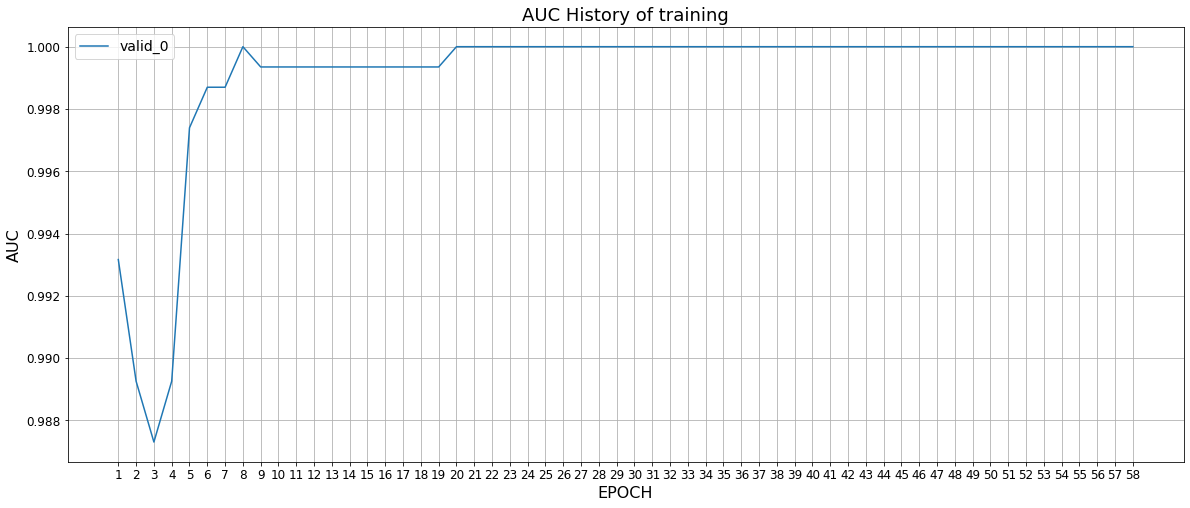

In [70]:
def plot_history(evals_result):
    for metric in ['auc']:
        plt.figure(figsize=(20,8))
        
        for key in evals_result.keys():
            history_len = len(evals_result.get(key)[metric])
            history = evals_result.get(key)[metric]
            x_axis = np.arange(1, history_len + 1)
            plt.plot(x_axis, history, label=key)
        
        x_ticks = list(filter(lambda e: (e % (history_len // 100 * 10) == 0) or e == 1, x_axis))
        plt.xticks(x_ticks, fontsize=12)
        plt.yticks(fontsize=12)

        plt.title(f'{metric.upper()} History of training', fontsize=18);
        plt.xlabel('EPOCH', fontsize=16)
        plt.ylabel(metric.upper(), fontsize=16)
        
        if metric in ['auc']:
            plt.legend(loc='upper left', fontsize=14)
        else:
            plt.legend(loc='upper right', fontsize=14)
        plt.grid()
        plt.show()

plot_history(evals_result)

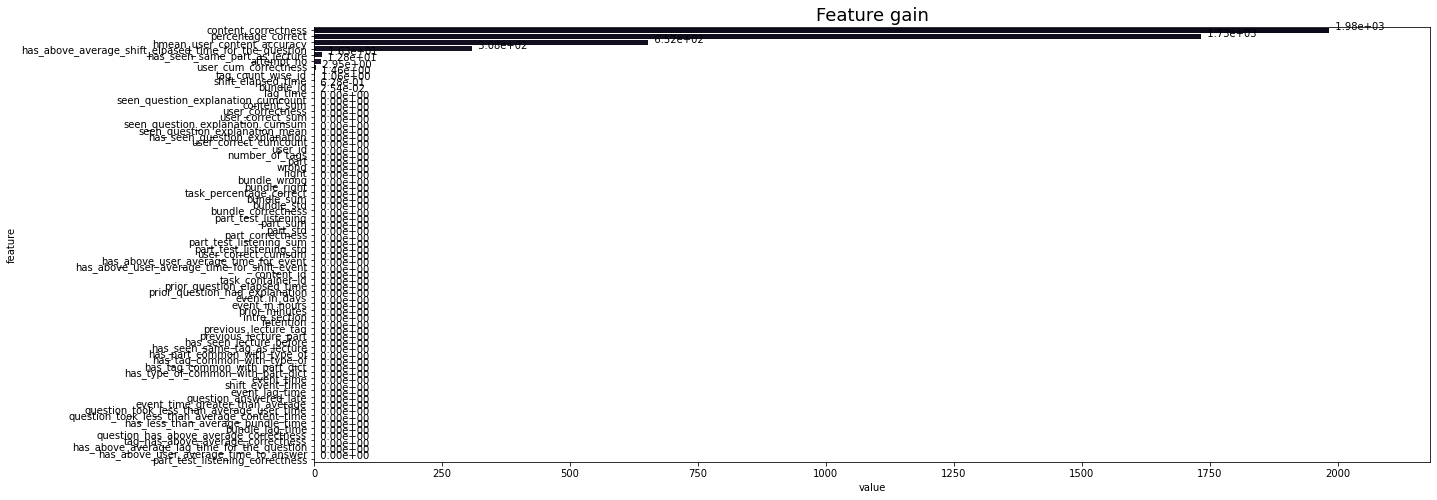

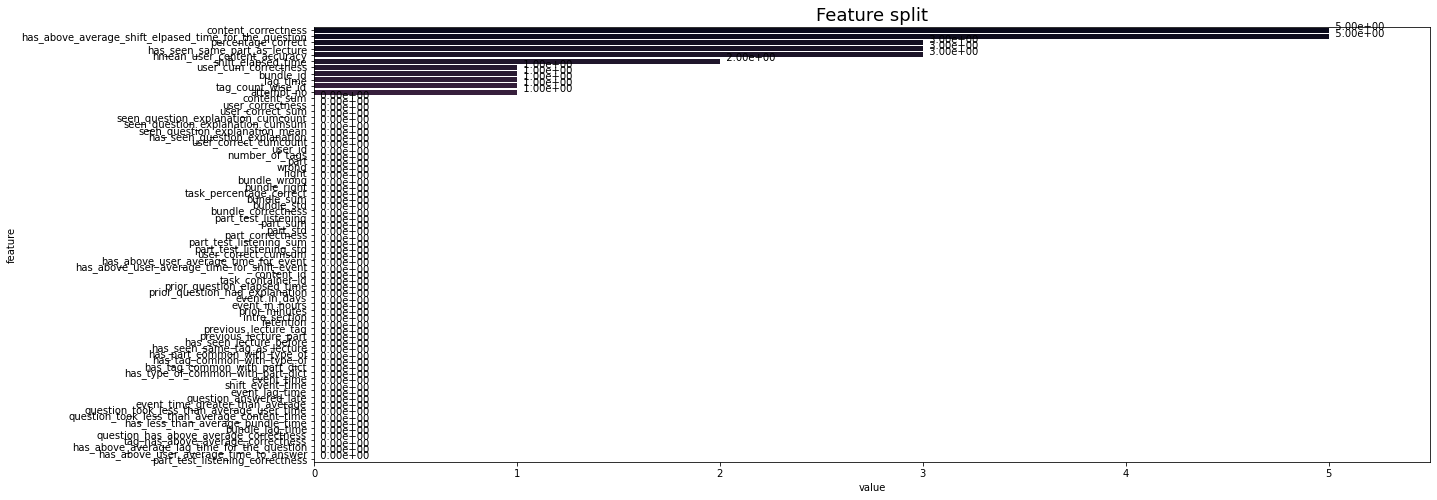

In [71]:
# plot the feature importance in terms of gain and split
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = features
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

In [72]:
# show tree and save as png
def save_tree_diagraph(model):
    tree_digraph = lgb.create_tree_digraph(model, show_info=['split_gain', 'internal_count'])

    tree_png = svg2png(tree_digraph._repr_svg_(), output_width=3840)
    tree_png = Image.open(BytesIO(tree_png))

    tree_png.save('create_tree_digraph.png')

    display(tree_png)
    
# save_tree_diagraph(model)

In [73]:
# remove train and validation data to free memory before prediction phase
del train_data
gc.collect()

49828

### Test set

In [74]:
class Iter_Valid(object):
    def __init__(self, df, max_user=1000):
        df = df.reset_index(drop=True)
        self.df = df
        self.user_answer = df['user_answer'].astype(str).values
        self.answered_correctly = df['answered_correctly'].astype(str).values
        df['prior_group_responses'] = "[]"
        df['prior_group_answers_correct'] = "[]"
        self.sample_df = df[df['content_type_id'] == 0][['row_id']]
        self.sample_df['answered_correctly'] = 0
        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self
    
    def fix_df(self, user_answer_list, answered_correctly_list, pre_start):
        df= self.df[pre_start:self.current].copy()
        sample_df = self.sample_df[pre_start:self.current].copy()
        df.loc[pre_start,'prior_group_responses'] = '[' + ",".join(self.pre_user_answer_list) + ']'
        df.loc[pre_start,'prior_group_answers_correct'] = '[' + ",".join(self.pre_answered_correctly_list) + ']'
        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):
        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1

        user_answer_list = []
        answered_correctly_list = []
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]
            if crr_content_type_id == 1:
                # no more than one task_container_id of "questions" from any single user
                # so we only care for content_type_id == 0 to break loop
                user_answer_list.append(self.user_answer[self.current])
                answered_correctly_list.append(self.answered_correctly[self.current])
                self.current += 1
                continue
            if crr_user_id in added_user and ((crr_user_id != pre_added_user) or (crr_task_container_id != pre_task_container_id)):
                # known user(not prev user or differnt task container)
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            if len(added_user) == self.max_user:
                if  crr_user_id == pre_added_user and crr_task_container_id == pre_task_container_id:
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(self.answered_correctly[self.current])
                    self.current += 1
                    continue
                else:
                    return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()

In [75]:
target_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
50000000,50000000,72364,1059622238,1278,0,3,3,1,24000.0,False
50000001,50000001,164482,1059622238,2065,0,4,0,0,16000.0,False
50000002,50000002,164482,1059622238,2063,0,4,0,1,16000.0,False
50000003,50000003,164482,1059622238,2064,0,4,0,0,16000.0,False
50000004,50000004,233096,1059622238,3363,0,5,0,0,28666.0,False
...,...,...,...,...,...,...,...,...,...,...
52499995,52499995,21456062489,1112835872,5606,0,455,0,0,43000.0,True
52499996,52499996,21456231859,1112835872,4992,0,456,0,1,40000.0,True
52499997,52499997,21456285224,1112835872,6125,0,457,0,0,26000.0,True
52499998,52499998,21456306804,1112835872,8295,0,458,1,1,46000.0,True


### prediction

In [76]:
print('prediction started')

def set_predict(df):
    predicted.append(df)

if KAGGLE:
    iter_test = env.iter_test()
    set_predict = env.predict
else:
    target_df = target_df.sample(frac=1).reset_index(drop=True)
    iter_test = Iter_Valid(target_df, max_user=1000)
    predicted = []

prediction started


In [93]:
# train_df_copy = train_df.copy()
train_df = train_df_copy

In [94]:
def sort_rows_with_respect_to_input(df, sorter):
    # Create the dictionary that defines the order for sorting
    sorterIndex = dict(zip(sorter, range(len(sorter))))

    # Generate a rank column that will be used to sort
    # the dataframe numerically
    df['row_id_Rank'] = df['row_id'].map(sorterIndex)

    # Here is the result asked with the lexicographic sort
    # Result may be hard to analyze, so a second sorting is
    # proposed next
    ## NOTE: 
    ## Newer versions of pandas use 'sort_values' instead of 'sort'
    df.sort_values(['row_id_Rank'], inplace = True)
    df.drop('row_id_Rank',  inplace = True)
    print(df)
    return df

In [96]:
train_df.has_seen_question_explanation = train_df.has_seen_question_explanation.fillna(False).astype(np.bool)

required_columns = ['user_id', 'answered_correctly']
user_cum_correctness_dict, user_correct_cumsum_dict, user_correct_cumcount_dict = get_cum_sum_std_correctness_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['user_id', 'has_seen_question_explanation']
has_seen_ques_cum_correctness_dict, has_seen_ques_correct_cumsum_dict, has_seen_ques_correct_cumcount_dict = get_cum_sum_std_correctness_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['user_id', 'answered_correctly']
user_sum_dict, user_var_dict, user_count_dict, user_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['content_id', 'answered_correctly']
content_sum_dict, content_var_dict, content_count_dict, content_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['bundle_id', 'answered_correctly']
bundle_sum_dict, bundle_var_dict, bundle_count_dict, bundle_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['part', 'answered_correctly']
part_sum_dict, part_var_dict, part_count_dict, part_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])

required_columns = ['part_test_listening', 'answered_correctly']
part_test_listening_sum_dict, part_test_listening_var_dict, part_test_listening_count_dict, part_test_listening_correctness_dict = get_sum_std_correctness_agg_dict(train_df[required_columns], required_columns[0], required_columns[1])


sort_ids = []
pbar = tqdm(total=2500000, position=0, leave=True)


# if not test_df.empty:
# for index, (_, test_df) in enumerate(iter_test):
for index, (test_df, _) in enumerate(iter_test):
# test_df, _ = next(iter_test)
# if not test_df.empty:

    if index != 0:
        # Do the operation for populating the values for the question answers
        previous_test_df['answered_correctly'] = eval(test_df['prior_group_answers_correct'].iloc[0])
        previous_test_groups_dict = previous_test_df[['row_id', 'answered_correctly']].set_index('row_id').to_dict(orient='index')
        previous_group_filter = ((train_df['predict'] == True) & (train_df['answered_correctly'].isna()))
        train_df.loc[previous_group_filter, ['answered_correctly']] = train_df[previous_group_filter].apply(lambda row: previous_test_groups_dict[row.prediction_row_id].get('answered_correctly'), axis=1)

    train_df['predict'] = False
    previous_test_df = test_df.copy()
    sort_ids.extend(list(test_df['row_id'].values))

    test_df.rename(columns={'row_id': 'prediction_row_id'}, inplace=True)
    test_df.drop(['prior_group_answers_correct', 'prior_group_responses'], axis=1, inplace=True)
    test_df['predict'] = True
    sample_prediction_questions = (test_df.content_type_id == 0)
    temp_df = test_df[sample_prediction_questions].join(questions_df.set_index("question_id"), 'content_id', how='left')
    test_df.loc[test_df.content_type_id == 0, temp_df.columns] = temp_df

    del temp_df

    train_df = pd.concat([train_df, test_df])
    train_df = train_df.reset_index(drop=True)
    train_df.sort_values(['user_id', 'timestamp'], inplace=True)

    predict_filter = (train_df['predict'] == True)
    sample_prediction_users = test_df['user_id'].unique()
    must_predict_users = (train_df['user_id'].isin(sample_prediction_users))
    predicting_users_df = train_df[must_predict_users]
    predicting_users_rows_only_df = predicting_users_df[predict_filter]
    predicting_users_questions_only = (predicting_users_df['content_type_id'] == 0)
    check_answered_correctly = (predicting_users_df.answered_correctly == 1)

    # ##### 4. Now lets find out the lag time
    group_by_required_fields = ['user_id', 'timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation']
    prediction_users_grouped_by_df = predicting_users_df.loc[predicting_users_questions_only, group_by_required_fields].groupby('user_id')

    group_by_answered_correctly_fields = ['shift_elapsed_time', 'user_id', 'event_time', 'shift_event_time']
    prediction_users_answered_correctly_grouped_by_df = predicting_users_df.loc[check_answered_correctly, group_by_answered_correctly_fields].groupby('user_id')

    content_id_group_by_required_fields = ['prior_question_elapsed_time', 'content_id']
    prediction_content_grouped_by_df = predicting_users_df.loc[predicting_users_questions_only, content_id_group_by_required_fields].groupby(["content_id"])

    predicting_users_df.loc[predicting_users_questions_only, ['event_time', 'shift_event_time', 'shift_elapsed_time', 'has_seen_question_explanation', 'event_lag_time']] = list(zip(*get_shift_values(prediction_users_grouped_by_df, groupby=False)))
    predicting_users_df.has_seen_question_explanation = predicting_users_df.has_seen_question_explanation.fillna(False).astype(np.bool)

    # check average user answering time
    user_average_time_to_elapsed_dict = prediction_users_grouped_by_df.prior_question_elapsed_time.mean().to_dict()
    # check average question answering time
    average_question_prior_question_elapsed_time_dict = prediction_content_grouped_by_df.prior_question_elapsed_time.mean().to_dict()

    elapsed_time_mean_dict = prediction_users_answered_correctly_grouped_by_df.shift_elapsed_time.mean().to_dict()
    event_time_mean_dict = prediction_users_answered_correctly_grouped_by_df.event_time.mean().to_dict()
    shift_event_time_mean_dict = prediction_users_answered_correctly_grouped_by_df.shift_event_time.mean().to_dict()

    feature_generating_rows = [
        "timestamp",
        "predict",
        "user_id",
        "content_id",
        "content_type_id",
        "task_container_id",
        "prior_question_elapsed_time",
        "prior_question_had_explanation",
        "shift_elapsed_time",
        "shift_event_time",
        "event_time",
        "bundle_id",
        "part",
        "part_test_listening"
    ]

    event_in_days = []
    event_in_hours = []
    prior_minutes = []
    intro_sections = []
    retention = []
    previous_lecture_tag = []
    previous_lecture_part = []
    has_seen_lecture_before = []
    has_seen_same_tag_as_lecture = []
    has_seen_same_part_as_lecture = []
    has_part_common_with_type_of = []
    has_tag_common_with_type_of = []
    has_tag_common_with_part_dict = []
    has_type_of_common_with_part_dict = []
    lag_time = []
    bundle_lag_time = []
    question_answered_late = []
    event_time_greater_than_average = []
    question_took_less_than_average_user_time = []
    question_took_less_than_average_content_time = []
    has_less_than_average_bundle_time = []
    question_has_above_average_correctness = []
    tag_has_above_average_correctness = []
    has_above_average_lag_time_for_the_question = []
    has_above_average_shift_elpased_time_for_the_question = []
    has_above_user_average_time_to_answer = []
    has_above_user_average_time_for_event = []
    has_above_user_average_time_for_shift_event = []

    user_cum_correctness = []
    user_correct_cumsum = []
    user_correct_cumcount = []

    seen_question_explanation_mean = []
    seen_question_explanation_cumsum = []
    seen_question_explanation_cumcount = []

    user_correct_sum = []
    user_correct_std = []
    user_correctness = []

    content_sum = []
    content_std = []
    content_correctness = []
    bundle_sum = []
    bundle_std = []
    bundle_correctness = []
    part_sum = []
    part_std = []
    part_correctness = []
    part_test_listening_sum = []
    part_test_listening_std = []
    part_test_listening_correctness = []

    hmean_user_content_accuracy = []
    for row in predicting_users_df[feature_generating_rows].itertuples():
        if row.predict:
            # ### Set User specific features
            # ##### 1. Get timestamp as hours and minutes
            event_time_split = get_timestamp_in_parts(row)
            event_in_days.append(event_time_split[0])
            event_in_hours.append(event_time_split[1])

            prior_minutes.append(get_prior_elasped_time_in_parts(row))

            # ##### 2. Find the intro rows.
            if row.timestamp == 0 or row.task_container_id == 0 or row.content_id in intro_section_values:
                intro_sections.append(True)
            else:
                intro_sections.append(False)

        # ##### 3. The actions after the lectures should be tagged with something.
        time_related_feature_values = running_retention(row)
        retention.append(time_related_feature_values[0])
        previous_lecture_tag.append(time_related_feature_values[1])
        previous_lecture_part.append(time_related_feature_values[2])
        has_seen_lecture_before.append(time_related_feature_values[3])
        has_seen_same_tag_as_lecture.append(time_related_feature_values[4])
        has_seen_same_part_as_lecture.append(time_related_feature_values[5])
        has_part_common_with_type_of.append(time_related_feature_values[6])
        has_tag_common_with_type_of.append(time_related_feature_values[7])
        has_tag_common_with_part_dict.append(time_related_feature_values[8])
        has_type_of_common_with_part_dict.append(time_related_feature_values[9])

        if row.content_type_id == 0:
            lag_time_value = get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time)
            lag_time.append(lag_time_value)
            bundle_lag_time.append(get_bundle_lag_time(row))
            question_answered_late.append(has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time))
            event_time_greater_than_average.append(has_event_time_greater_than_average(row.content_id, row.shift_event_time))
            question_took_less_than_average_user_time.append(row.prior_question_elapsed_time < user_average_time_to_elapsed_dict.get(row.user_id, 0))
            question_took_less_than_average_content_time.append(row.prior_question_elapsed_time < average_question_prior_question_elapsed_time_dict.get(row.user_id, 0))
            has_less_than_average_bundle_time.append(row.shift_elapsed_time < bundle_time_relation_dict.get(row.content_id, {"average_time": 0})['average_time'])
            question_has_above_average_correctness.append(is_question_above_average_answering(row))
            tag_has_above_average_correctness.append(is_all_tags_above_average_answering(row))
            has_above_average_lag_time_for_the_question.append(lag_time_value > lag_time_answered_correctly_mean_dict.get(row.content_id, 0))
            has_above_average_shift_elpased_time_for_the_question.append(row.shift_elapsed_time > shift_elapsed_time_answered_correctly_mean_dict.get(row.content_id, 0))

            has_above_user_average_time_to_answer.append(elapsed_time_mean_dict.get(row.user_id, 0) <= row.shift_elapsed_time)
            has_above_user_average_time_for_event.append(event_time_mean_dict.get(row.user_id, 0) <= row.event_time)
            has_above_user_average_time_for_shift_event.append(shift_event_time_mean_dict.get(row.user_id, 0) <= row.shift_event_time)

            user_cum_correctness.append(user_cum_correctness_dict.get(row.user_id, 0))
            user_correct_cumsum.append(user_correct_cumsum_dict.get(row.user_id, 0))
            user_correct_cumcount.append(user_correct_cumcount_dict.get(row.user_id, 0))

            seen_question_explanation_mean.append(has_seen_ques_cum_correctness_dict.get(row.content_id, 0))
            seen_question_explanation_cumsum.append(has_seen_ques_correct_cumsum_dict.get(row.content_id, 0))
            seen_question_explanation_cumcount.append(has_seen_ques_correct_cumcount_dict.get(row.content_id, 0))

            user_correct_sum.append(user_sum_dict.get(row.user_id, 0))
            user_correct_std.append(user_var_dict.get(row.user_id, 0))
            user_correctness.append(user_count_dict.get(row.user_id, 0))

        content_sum.append(content_sum_dict.get(row.content_id, 0))
        content_std.append(content_var_dict.get(row.content_id, 0))
        content_correctness.append(content_correctness_dict.get(row.content_id, 0))
        bundle_sum.append(bundle_sum_dict.get(row.bundle_id, 0))
        bundle_std.append(bundle_var_dict.get(row.bundle_id, 0))
        bundle_correctness.append(bundle_correctness_dict.get(row.bundle_id, 0))
        part_sum.append(part_sum_dict.get(row.part, 0))
        part_std.append(part_var_dict.get(row.part, 0))
        part_correctness.append(part_correctness_dict.get(row.part, 0))
        part_test_listening_sum.append(part_test_listening_sum_dict.get(row.part_test_listening, 0))
        part_test_listening_std.append(part_test_listening_var_dict.get(row.part_test_listening, 0))
        part_test_listening_correctness.append(part_test_listening_correctness_dict.get(row.part_test_listening, 0))

        if (user_count_dict.get(row.user_id, 0) + content_correctness_dict.get(row.content_id, 0)) != 0:
            hmean_user_content_accuracy.append(2 * (
                (user_count_dict.get(row.user_id, 0) * content_correctness_dict.get(row.content_id, 0)) /
                (user_count_dict.get(row.user_id, 0) + content_correctness_dict.get(row.content_id, 0))
            ))
        else:
            hmean_user_content_accuracy.append(0)
    # ### Prepare first group test set with train_df
    # ##### 1. Get timestamp as hours and minutes

    predicting_users_rows_only_df[
        [
            'event_in_days',
            'event_in_hours',
            'prior_minutes',
            'intro_section'
        ]
    ] = list(zip(event_in_days, event_in_hours, prior_minutes, intro_sections))

    # ======================================
    predicting_users_df.loc[predict_filter] = predicting_users_rows_only_df
    del predicting_users_rows_only_df
    # ======================================
    # ##### 3. The actions after the lectures should be tagged with something.
    predicting_users_df[
        [
            "retention",
            "previous_lecture_tag",
            "previous_lecture_part",
            "has_seen_lecture_before",
            "has_seen_same_tag_as_lecture",
            "has_seen_same_part_as_lecture",
            "has_part_common_with_type_of",
            "has_tag_common_with_type_of",
            "has_tag_common_with_part_dict",
            "has_type_of_common_with_part_dict",
        ]
    ] = list(zip(
        retention,
        previous_lecture_tag,
        previous_lecture_part,
        has_seen_lecture_before,
        has_seen_same_tag_as_lecture,
        has_seen_same_part_as_lecture,
        has_part_common_with_type_of,
        has_tag_common_with_type_of,
        has_tag_common_with_part_dict,
        has_type_of_common_with_part_dict,
    ))

    # Make train df only question and not lectures
    # ======================================
    # train_df_elapsed_time_groupby = predicting_users_df[['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time
    # individual_question_min_time_dict = train_df_elapsed_time_groupby.min().to_dict()
    # individual_question_mean_time_dict = train_df_elapsed_time_groupby.mean().to_dict()

    # average_question_timestamp_difference_dict = train_df[(train_df['shift_event_time'] < 3600000)][['content_id', 'shift_event_time']].groupby('content_id').shift_event_time.mean().to_dict()

    # del train_df_elapsed_time_groupby
    # ======================================
    predicting_users_df.loc[
        predicting_users_questions_only,
        [
            'lag_time',
            'bundle_lag_time',
            'question_answered_late',
            'event_time_greater_than_average',
            'question_took_less_than_average_user_time',
            'question_took_less_than_average_content_time',
            'has_less_than_average_bundle_time',
            'question_has_above_average_correctness',
            'tag_has_above_average_correctness',
            'has_above_average_lag_time_for_the_question',
            'has_above_average_shift_elpased_time_for_the_question',
            'has_above_user_average_time_to_answer',
            'has_above_user_average_time_for_event',
            'has_above_user_average_time_for_shift_event',
            'user_cum_correctness',
            'user_correct_cumsum',
            'user_correct_cumcount',
            'seen_question_explanation_mean',
            'seen_question_explanation_cumsum',
            'seen_question_explanation_cumcount',
            'user_correct_sum',
            'user_correct_std',
            'user_correctness',
            'content_sum',
            'content_std',
            'content_correctness',
            'bundle_sum',
            'bundle_std',
            'bundle_correctness',
            'part_sum',
            'part_std',
            'part_correctness',
            'part_test_listening_sum',
            'part_test_listening_std',
            'part_test_listening_correctness',
            'hmean_user_content_accuracy'
        ]
    ] = list(zip(
        lag_time,
        bundle_lag_time,
        question_answered_late,
        event_time_greater_than_average,
        question_took_less_than_average_user_time,
        question_took_less_than_average_content_time,
        has_less_than_average_bundle_time,
        question_has_above_average_correctness,
        tag_has_above_average_correctness,
        has_above_average_lag_time_for_the_question,
        has_above_average_shift_elpased_time_for_the_question,
        has_above_user_average_time_to_answer,
        has_above_user_average_time_for_event,
        has_above_user_average_time_for_shift_event,
        user_cum_correctness,
        user_correct_cumsum,
        user_correct_cumcount,
        seen_question_explanation_mean,
        seen_question_explanation_cumsum,
        seen_question_explanation_cumcount,
        user_correct_sum,
        user_correct_std,
        user_correctness,
        content_sum,
        content_std,
        content_correctness,
        bundle_sum,
        bundle_std,
        bundle_correctness,
        part_sum,
        part_std,
        part_correctness,
        part_test_listening_sum,
        part_test_listening_std,
        part_test_listening_correctness,
        hmean_user_content_accuracy
    ))

    # ##### 7. The prior time mean for each user should be averaged to check if the user too more than usual
    # TODO: Do the following by setting the time rather than setting the flag
    # BUG: The comparison seems to be wrong 
    
    # ======================================
    
    # ##### 10. The attempt feature
    predicting_users_df["attempt_no"] = 1
    predicting_users_df.attempt_no = predicting_users_df.attempt_no.astype('int8')
    predicting_users_df["attempt_no"] = predicting_users_df[["user_id", "content_id", "attempt_no"]].groupby(["user_id", "content_id"])["attempt_no"].cumsum()


    # ======================================


    predict_df = predicting_users_df[(predicting_users_df.content_type_id == 0)]

    train_df.loc[must_predict_users] = predicting_users_df
    del predicting_users_df
    boolean_columns = [
        "prior_question_had_explanation",
        "intro_section",
        "has_seen_lecture_before",
        "has_seen_same_tag_as_lecture",
        "has_seen_same_part_as_lecture",
        "has_part_common_with_type_of",
        "has_tag_common_with_type_of",
        "has_tag_common_with_part_dict",
        "has_type_of_common_with_part_dict",
        "question_answered_late",
        "event_time_greater_than_average",
        "question_took_less_than_average_user_time",
        "question_took_less_than_average_content_time",
        "has_less_than_average_bundle_time",
        "question_has_above_average_correctness",
        "tag_has_above_average_correctness",
        "has_above_average_lag_time_for_the_question",
        "has_above_average_shift_elpased_time_for_the_question",
        "has_above_user_average_time_to_answer",
        "has_above_user_average_time_for_event",
        "has_above_user_average_time_for_shift_event",
        "part_test_listening",
        "has_seen_question_explanation"
    ]

    predict_df[boolean_columns] = predict_df[boolean_columns].fillna(False).astype(np.bool)
    prediction_row_ids = predict_df.prediction_row_id.values
    predictions_list  = model.predict(predict_df[features])

    predictions_df = pd.DataFrame({'row_id': prediction_row_ids, 'answered_correctly': predictions_list})
    set_predict(predictions_df)

    del predictions_df
    del predict_df
    pbar.update(len(predictions_list))
print('prediction done')


  2%|▏         | 47510/2500000 [00:41<25:36, 1596.48it/s]

KeyboardInterrupt: 

In [ ]:
if KAGGLE:
    y_true = target_df[target_df.content_type_id == 0].answered_correctly
    y_pred = pd.concat(predicted).answered_correctly
    print('validation auc:', roc_auc_score(y_true, y_pred))


In [ ]:
dtypes = {
    'row_id': 'int64',
    'answered_correctly': 'float32'
}
submission_df = pd.read_csv('submission.csv', dtype=dtypes)
submission_df = sort_rows_with_respect_to_input(submission_df, sort_ids)
submission_df.to_csv('submission.csv', index=False)

In [ ]:
# code you want to evaluate
elapsed = timeit.default_timer() - start_time
import datetime
print(str(datetime.timedelta(seconds=elapsed)))

- Validation set needs to be done
- The lecture thing should be done
- The luckyness which we saw needs to be checked
- The pending items in the feature set also needed to be done